In [46]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
import math
import statsmodels.api as sm


In [48]:
# Set the ticker and date rang
ticker = 'tsla'
start = datetime.datetime(2022, 10, 1)
end = datetime.datetime(2024, 9, 30)
# Download the data
stock = yf.download(ticker, start=start, end=end)
# Extract only the "Adj Close" column
stock_adj_close = stock['Adj Close']
# Calculate daily returns
stock_daily_returns = stock_adj_close.pct_change()*100
# Replace NaN values with 0
stock_daily_returns = stock_daily_returns.fillna(0)
# Create a DataFrame with a proper column name
stock_daily_returns_df = pd.DataFrame(stock_daily_returns)
stock_daily_returns_df.columns = ['Returns']
# Print the first few rows
print(stock_daily_returns_df.head())

[*********************100%***********************]  1 of 1 completed

             Returns
Date                
2022-10-03  0.000000
2022-10-04  2.904294
2022-10-05 -3.459752
2022-10-06 -1.112908
2022-10-07 -6.324276


In [49]:
# Get descriptive statistics for the 'Return' variable
return_stats = stock_daily_returns_df['Returns'].describe()
print(return_stats)

count    500.000000
mean       0.079847
std        3.621299
min      -12.334605
25%       -1.936325
50%        0.127330
75%        1.975456
max       15.306917
Name: Returns, dtype: float64


## Plot the price movement (adjusted close prices)

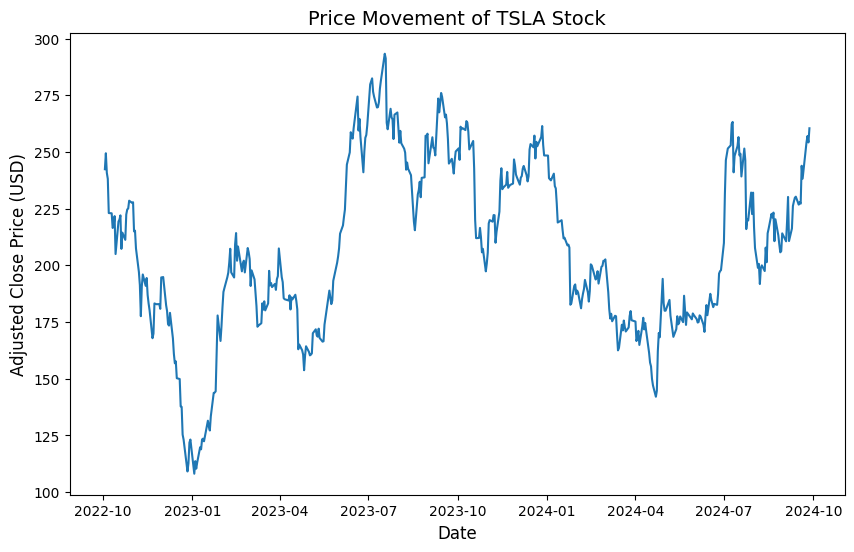

In [4]:
plt.figure(figsize=(10, 6))

# Plot the adjusted closing price
sns.lineplot(data=stock_adj_close)

# Add titles and labels
plt.title(f'Price Movement of {ticker.upper()} Stock', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price (USD)', fontsize=12)

# Show the plot
plt.show()

## Plot the daily returns movement

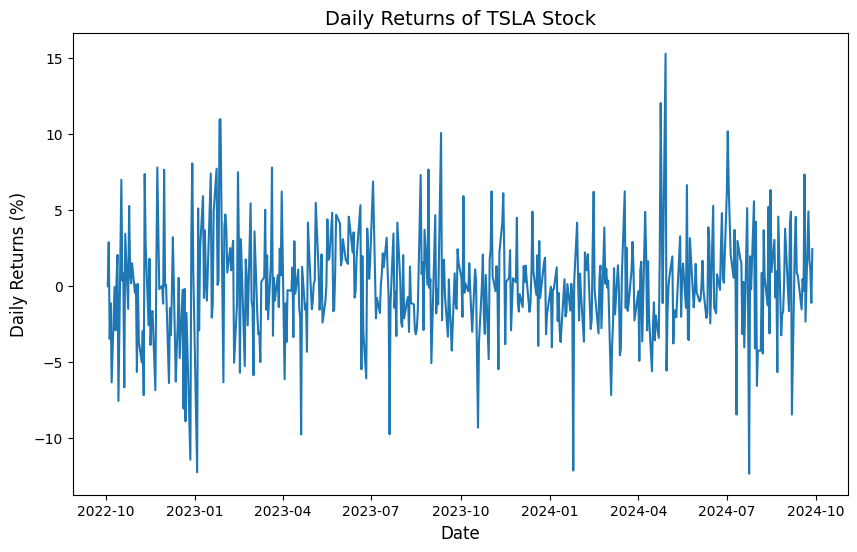

In [5]:
plt.figure(figsize=(10,6))

# Use seaborn to plot the returns with a line plot
sns.lineplot(data=stock_daily_returns_df, x=stock_daily_returns_df.index, y='Returns')

# Add titles and labels
plt.title(f'Daily Returns of {ticker.upper()} Stock', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Returns (%)', fontsize=12)

# Show the plot
plt.show()

##Calendar Anomalies: French

In [50]:
import datetime
import statsmodels.api as sm
import pandas as pd

In [51]:
# Add a new column for the weekday (0=Monday, 1=Tuesday, ..., 6=Sunday)
stock_daily_returns_df['Weekday'] = stock.index.weekday

# Map weekday numbers to their names
stock_daily_returns_df['Weekday Name'] = stock_daily_returns_df['Weekday'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [52]:
print(stock_daily_returns_df.head())

             Returns  Weekday Weekday Name
Date                                      
2022-10-03  0.000000        0       Monday
2022-10-04  2.904294        1      Tuesday
2022-10-05 -3.459752        2    Wednesday
2022-10-06 -1.112908        3     Thursday
2022-10-07 -6.324276        4       Friday


In [53]:
dependent_variable = stock_daily_returns_df['Returns']


In [54]:
# Create dummy variables for weekdays, excluding Monday as a baseline
independent_variables = pd.get_dummies(stock_daily_returns_df['Weekday'], drop_first=True, dtype=float) # changed to dtype=float

# Rename columns for clarity ('Tuesday', 'Wednesday', etc.)
independent_variables.columns = ['Tuesday', 'Wednesday', 'Thursday', 'Friday'] #The values in Weekday are now numeric so this should be ok

# Add a constant (intercept) to the independent variables
independent_variables_with_constant = sm.add_constant(independent_variables)

# Ensure dependent variable is numeric
dependent_variable = pd.to_numeric(dependent_variable, errors='coerce') # Added to handle potential non-numeric values


In [55]:
# Run the regression
model = sm.OLS(dependent_variable, independent_variables_with_constant).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7781
Date:                Sun, 20 Oct 2024   Prob (F-statistic):              0.540
Time:                        08:53:05   Log-Likelihood:                -1350.8
No. Observations:                 500   AIC:                             2712.
Df Residuals:                     495   BIC:                             2733.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5276      0.380      1.388      0.1

#MSTL method

In [56]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt

Text(0.5, 0, 'Weekday')

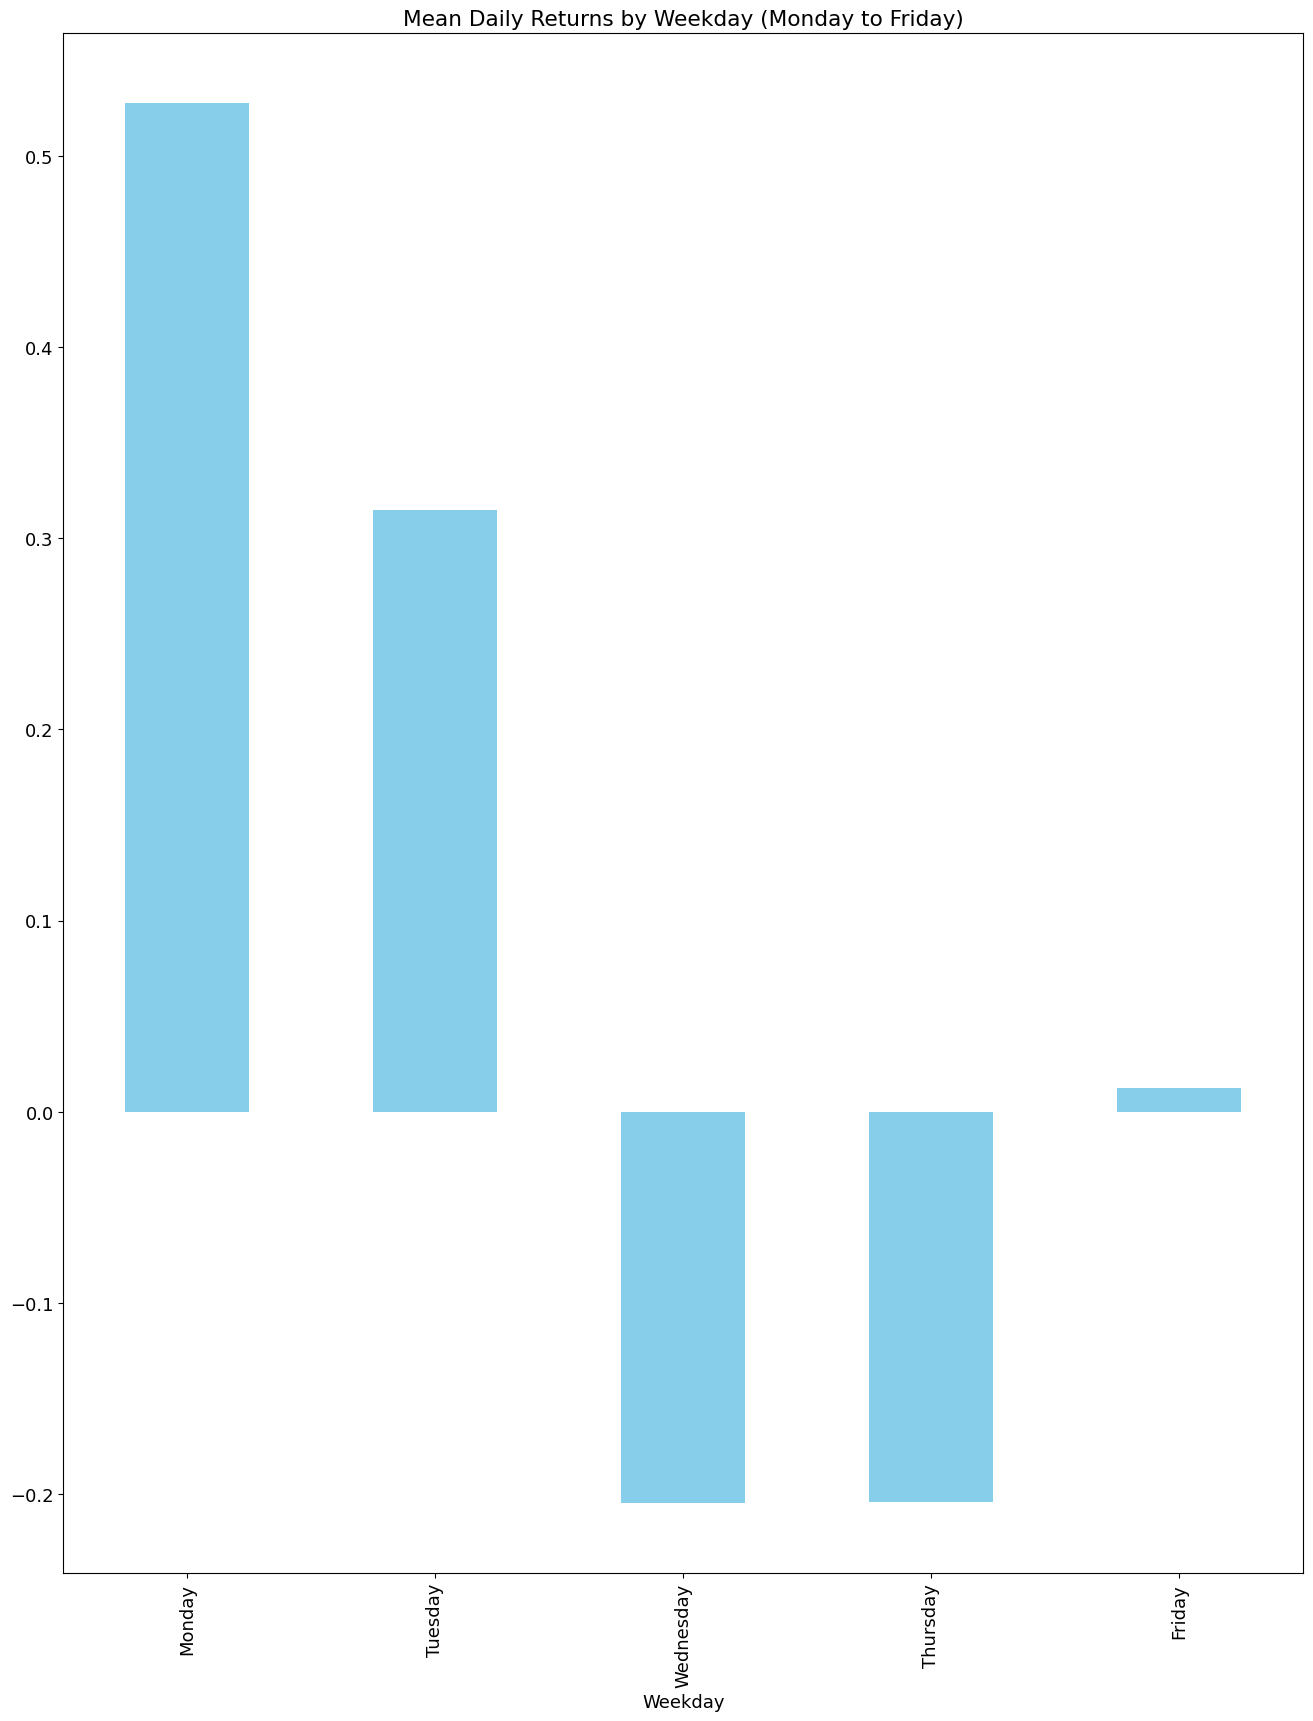

In [57]:
weekday_data = stock_daily_returns_df[stock_daily_returns_df['Weekday Name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
mean_weekday_returns = weekday_data.groupby('Weekday Name')['Returns'].mean()
mean_weekday_returns = mean_weekday_returns[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
mean_weekday_returns.plot(kind='bar', color='skyblue')
plt.title('Mean Daily Returns by Weekday (Monday to Friday)')
plt.xlabel('Weekday')

In [58]:
mstl = MSTL(stock_daily_returns_df["Returns"], periods=(5, 7), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()

In [59]:
res.trend.head()

,trend
Date,
2022-10-03,-1.084091
2022-10-04,-1.224070
2022-10-05,-1.319232
2022-10-06,-1.380582
2022-10-07,-1.425605


In [60]:
res.seasonal.head()

,seasonal_5,seasonal_7
Date,,
2022-10-03,0.216913,0.417333
2022-10-04,1.642866,-0.020080
2022-10-05,-1.167762,0.131859
2022-10-06,0.568449,0.604657
2022-10-07,-1.165930,-1.283721


In [62]:
res.resid.head()

,resid
Date,
2022-10-03,0.449845
2022-10-04,2.505579
2022-10-05,-1.104616
2022-10-06,-0.905432
2022-10-07,-2.449020


#Plot the results

<ipython-input-63-54a62ed94b1c>:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, ax_last)


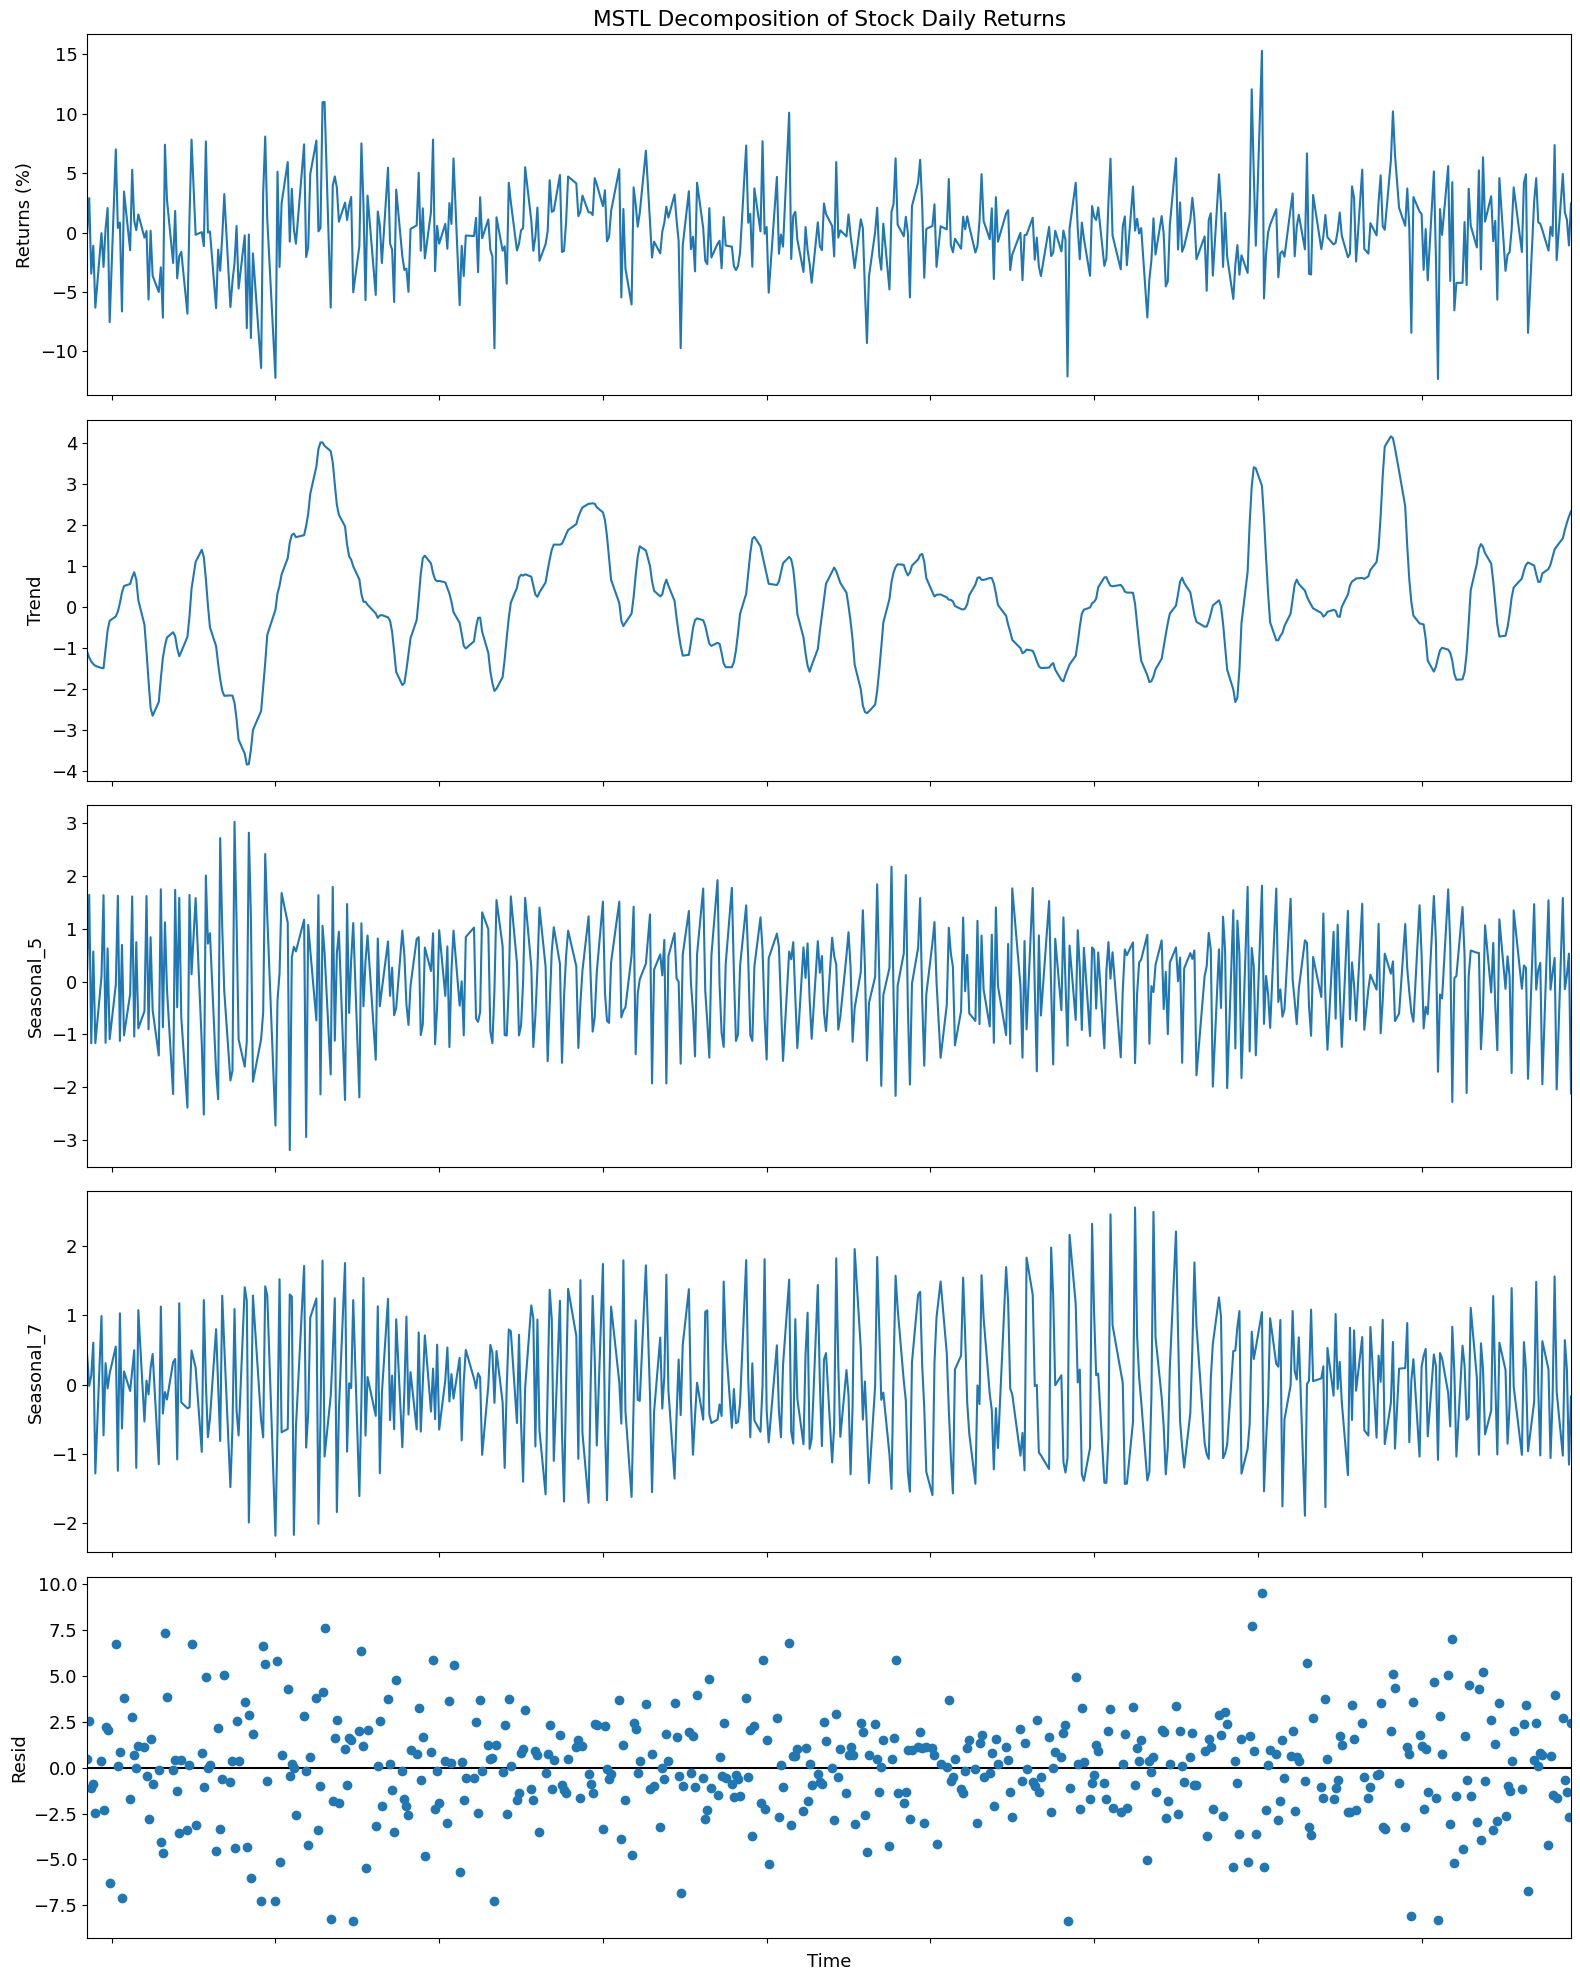

In [63]:
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()
axs = fig.get_axes()
ax_last = axs[-1]
num_ticks = 10
start_date = stock_daily_returns_df.index[0]
end_date = stock_daily_returns_df.index[-1]
ax_last.xaxis.set_major_locator(plt.MaxNLocator(num_ticks))

# Ensure x-axis tick labels are rotated properly and aligned
plt.setp(ax_last.get_xticklabels(), rotation=45, horizontalalignment="right")
for ax in axs[:-1]:
    ax.get_shared_x_axes().join(ax, ax_last)
    ax.xaxis.set_major_locator(plt.MaxNLocator(num_ticks))
    ax.set_xticklabels([])

axs[0].set_ylabel("Returns (%)")
axs[0].set_title("MSTL Decomposition of Stock Daily Returns")
ax_last.set_xlabel("Time")
plt.tight_layout()
plt.show()


Plot the anomaly of weekend in each month

In [66]:
import calendar
import numpy as np

In [67]:
# Assuming you have your MSTL results in `res`
seasonal_values = res.seasonal

# Extract seasonal components for each month (5 and 7-day seasonality)
monthly_seasonal = {}
for month in range(1, 13):  # Months from January (1) to December (12)
    monthly_seasonal[month] = []

# Populate the monthly seasonal values
# Use DataFrame.iterrows() instead of iteritems() to iterate over the rows of the DataFrame
for date, row in seasonal_values.iterrows():
    month = date.month
    # Access the seasonal value (assuming it's in a column named 'seasonal')
    value = row['seasonal_5'] + row['seasonal_7']  # Adjust column name if different
    monthly_seasonal[month].append(value)

# Convert lists to numpy arrays for easy plotting
monthly_seasonal = {month: np.array(values) for month, values in monthly_seasonal.items()}

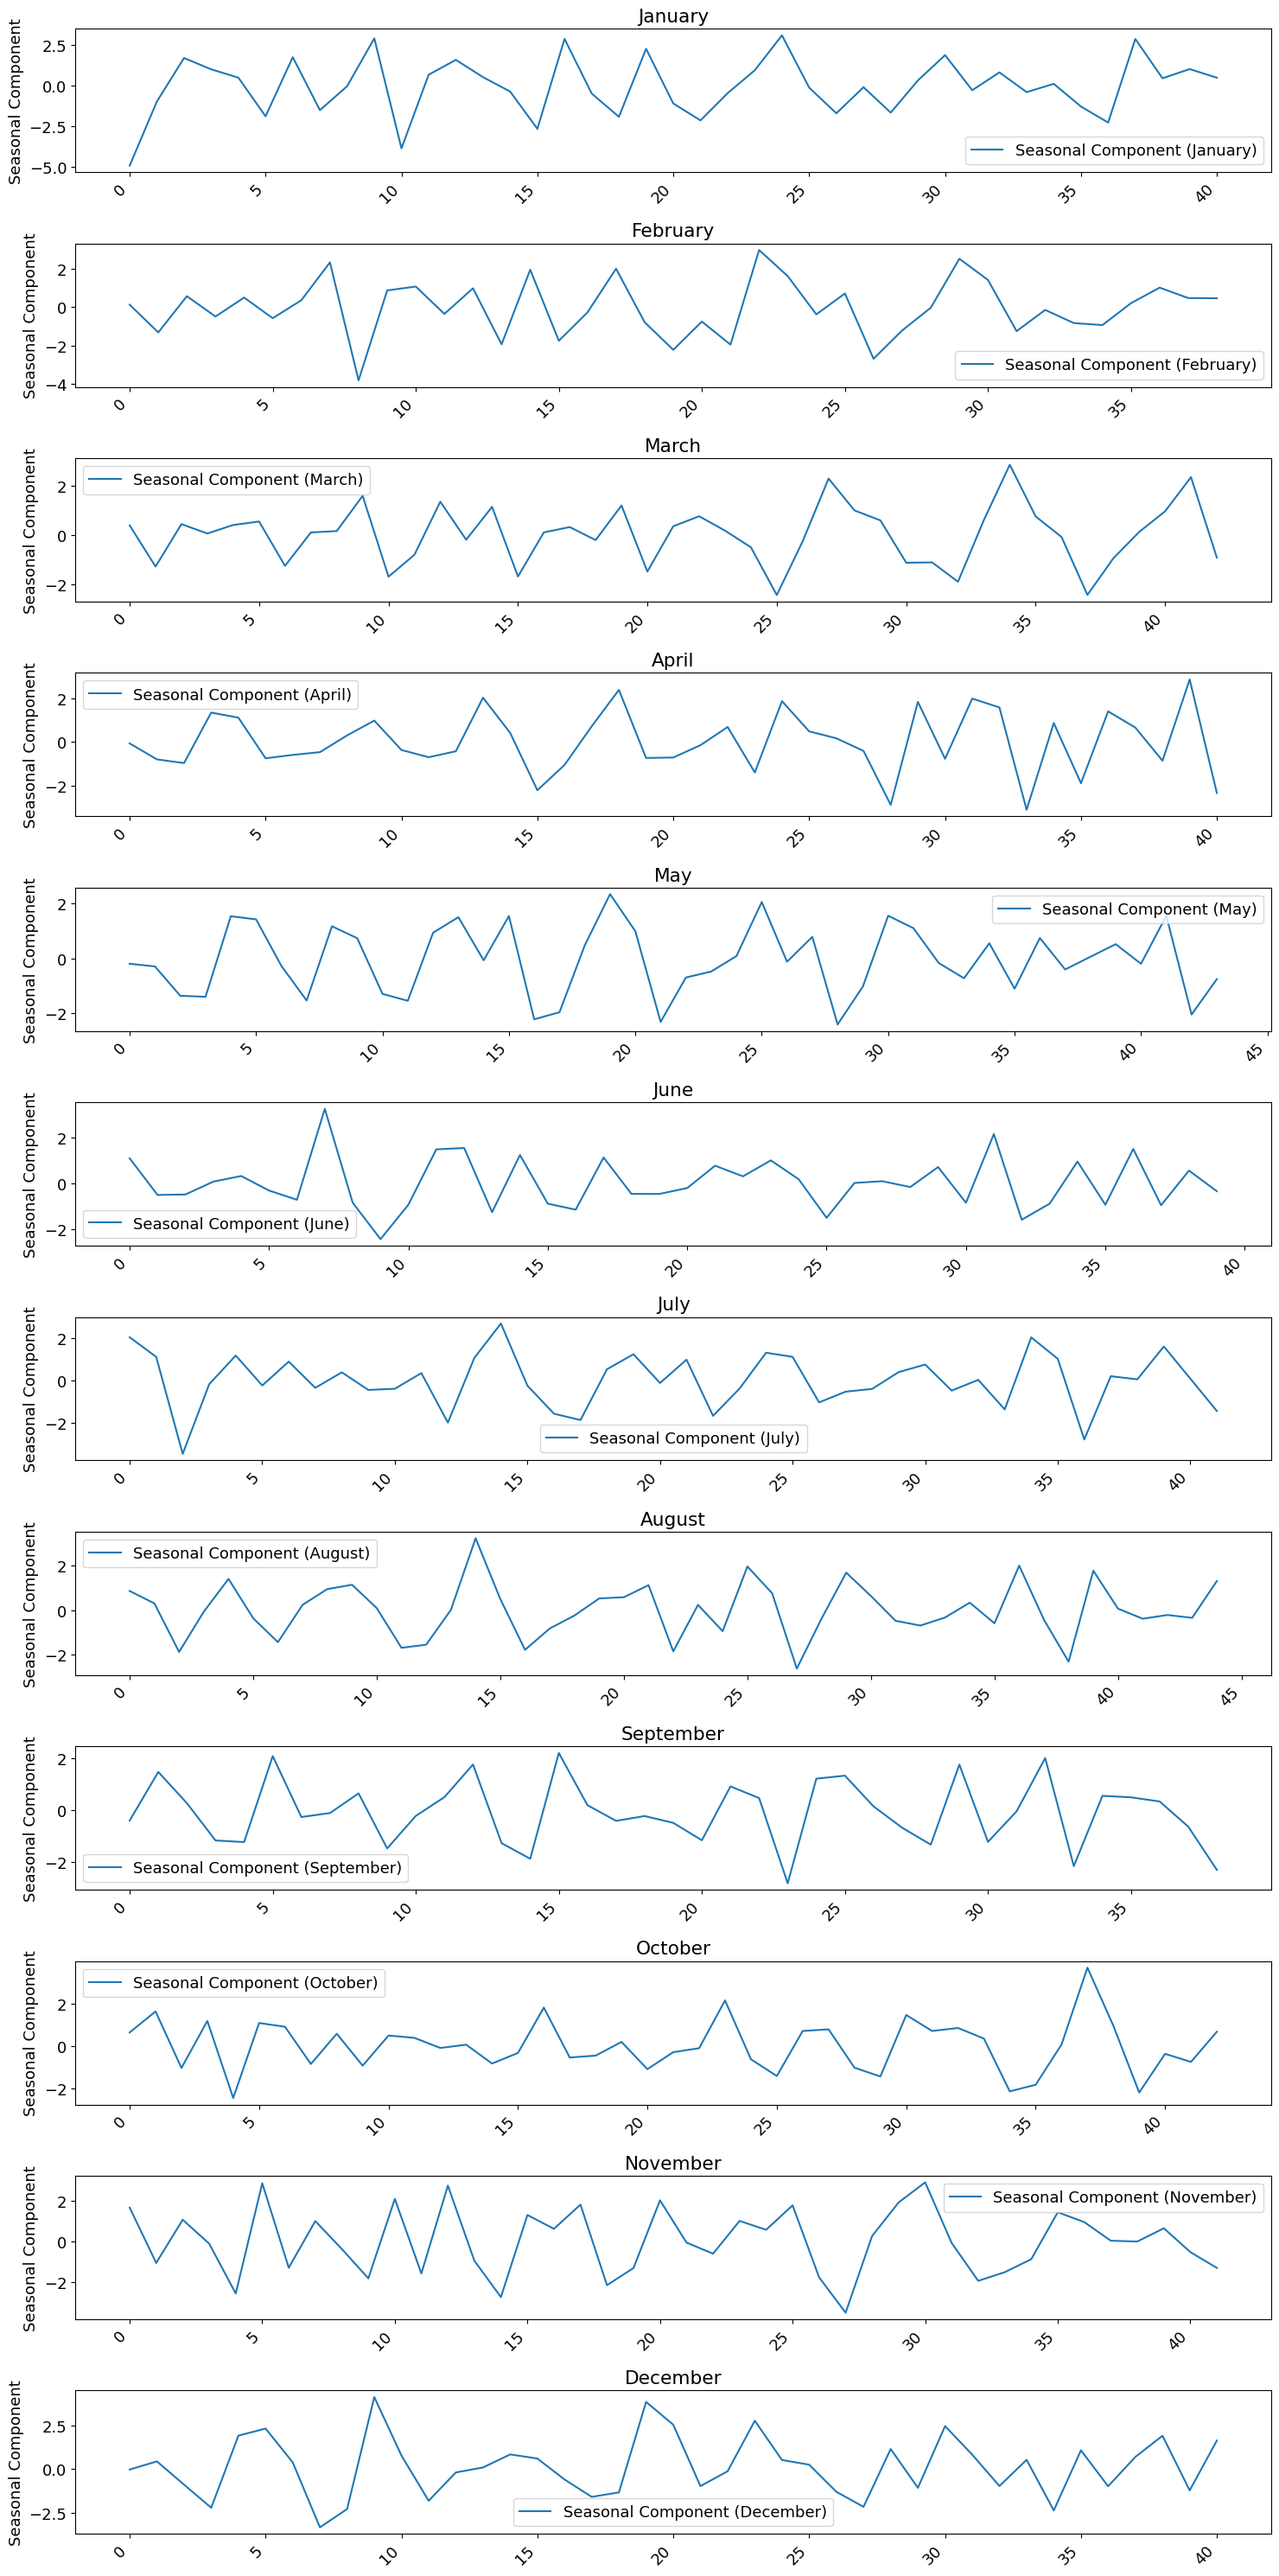

In [68]:
# Create subplots for each month (12 months total)
fig, ax = plt.subplots(nrows=12, figsize=[15, 30])
ax = ax.flatten()

# List of month names for labeling the plots
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Plot the seasonal values for each month
for month in range(1, 13):
    if len(monthly_seasonal[month]) > 0:
        ax[month - 1].plot(monthly_seasonal[month], label=f"Seasonal Component ({month_names[month - 1]})")
        ax[month - 1].set_title(month_names[month - 1])
        ax[month - 1].set_ylabel("Seasonal Component")
        ax[month - 1].legend()

# Optional: Adjust x-axis labels and ticks
for i in range(12):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit number of x ticks
    plt.setp(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()